In [47]:
import pandas as pd 
import numpy as np                     
import matplotlib.pyplot as plot                         
import statsmodels.api as smf 
from ib_insync import *
util.startLoop()
from statsmodels.tsa.stattools import coint
import yfinance as yf
from datetime import datetime 
from dateutil.relativedelta import relativedelta
import time
import requests
import io
import math
import scipy
from scipy.spatial.distance import cdist
import itertools as it

In [48]:
#calculate ssd
def ssd(a1,a2):
    answer = sum((a1-a2)**2)
    return answer

#help funtion to find spread and Zscore
def spread(ticker1,ticker2):
    S1 = log_data[ticker1]
    S2 = log_data[ticker2]
    S1 = smf.add_constant(S1, has_constant='add')
    results = smf.OLS(S2, S1).fit()
    S1 = S1[ticker1]
    b = results.params[ticker1]
    spread = S2 - b * S1
    z_score = (spread - spread.mean()) / np.std(spread)
    mean = spread.mean()
    std = np.std(spread)
    return spread,z_score,b,mean,std

#place market order
def market_order(contract, num, dryrun=False):
    if num > 0:
        order = MarketOrder("BUY", num)
    elif num < 0:
        order = MarketOrder("SELL", abs(num))
    else:
        return None
    if dryrun:
        return ibconn.whatIfOrder(contract, order)
    else:
        return ibconn.placeOrder(contract, order)


def trade(num):
    if abs(top20_copy['Z-score'][num]) > 1:
        if top20_copy['Z-score'][num] > 1:
            action1 = "SEll"
            name1 = top20_copy['StockA'][num]
            share1 = round(spread(top20_copy['StockA'][num],top20_copy['StockB'][num])[2]*100)
            action2 = "BUY"
            name2 = top20_copy['StockB'][num]
            share2 = round((1/spread(top20_copy['StockA'][num],top20_copy['StockB'][num])[2])*100)
        else:
            action3 = "BUY"
            name3 = top20_copy['StockA'][num]
            action4 = "SELL"
            name4 = top20_copy['StockB'][num]
        
    # return contract and order required to remain delta neutral
        contract = Stock(name, "SMART", "USD")
        ib.qualifyContracts(contract)
        order = mmarket_order(spread(top20_copy['StockA'][num],top20_copy['StockB'][num])[2]*100) #hegde ratio
        
        # place trade
        trade = ib.placeOrder(contract, order)
        assert order in ib.orders()
        assert trade in ib.trades()
        while not trade.isDone():
            ib.waitOnUpdate()
    else:
        print("Not in the range")

        
def rebalance(num):
    # account value
    act = ibconn.accountSummary()
    portfolio_val = float(act[19].value)
    
    # max position size
    max_position = 0.05 * portfolio_val

    [p1, p2] = ibconn.reqTickers(*contracts)
     max_allotment = min(
            portfolio_val / (len(paird) * 2), max_position
        )

    spread = np.log(p1.last) - spread[1] * log(p2.last)
    z_score = (spread[0] - spread[3]) / spread[4]
    
    filter = [p for p in positions if p.contract.symbol in pairs]

    # exit any open pairs traded positions
    positions = [p for p in ibconn.positions() if p.contract.secType == "STK"]
    
    # set the allocation based on the first security
    allocation = np.floor(max_allotment / p1.last)

    # if the szcore is small and positions are open, liquidate them
    if abs(z_score) < 1 and len(filter) > 0:
        for stk in filter:
            print(f"Zscore is {z_score} - closing {pairs} positions...")
        market_order(stk.contract, -1 * stk.position)
        
    # if the zscore exceeds 1 and no positions are open, long or short the spread
    lif z_score > 1 and len(filter) == 0:
        print(
            f"Zscore is {z_score} - shorting {pairs} spread with allocation of {allocation}"
                )
        market_order(sec1, -1 * allocation)
        market_order(sec2, np.floor(allocation * row.hedge_ratio))
        elif z_score < -1 and len(filter) == 0:
            print(
                f"Zscore is {z_score} - long {pair} spread with allocation of {allocation}"
                )
        market_order(sec1, allocation)
        market_order(sec2, np.floor(-1 * allocation * row.hedge_ratio))
        else:
            print(f"Zscore is {z_score} - no action for {pair} spread...")


In [49]:
#set start and end date
start=datetime.today() - relativedelta(months=+12)
end = datetime.today()

In [50]:
#get all tickers from the link
url = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")[0]
tickers = url.Symbol.to_list()

In [ ]:
#download stock data from Yahoo Finance
stock_final = pd.DataFrame()
# iterate over each symbol
for i in tickers:  
    try:
        # download the stock price 
        stock = []
        stock = yf.download(i,start=start, end=end, progress=False)
        
        # append the individual stock prices 
        if len(stock) == 0:
            None
        else:
            stock['ticker']=i
            stock_final = stock_final.append(stock,sort=False)
    except Exception:
        None

In [52]:
stock_final

,Open,High,Low,Close,Adj Close,Volume,ticker
Date,,,,,,,
2022-02-02,167.800003,169.250000,165.800003,166.660004,159.880905,3191300,MMM
2022-02-03,166.259995,166.729996,164.100006,164.389999,157.703247,2608700,MMM
2022-02-04,163.789993,164.740005,160.100006,160.729996,154.192108,4046500,MMM
2022-02-07,160.750000,162.309998,160.009995,161.169998,154.614227,2441100,MMM
2022-02-08,161.429993,163.110001,160.320007,162.410004,155.803787,2373900,MMM
...,...,...,...,...,...,...,...
2023-01-26,166.869995,168.300003,166.119995,168.240005,168.240005,1530700,ZTS
2023-01-27,166.979996,167.690002,164.500000,165.179993,165.179993,1831700,ZTS
2023-01-30,164.000000,165.630005,163.820007,164.699997,164.699997,1950600,ZTS


In [53]:
#replace NaN to 0 so we can screen out all stocks that have one or more days with no trade.
stock_final['Volume'] = stock_final['Volume'].fillna(0).astype(int)
data2 = stock_final.groupby('ticker').apply(lambda x: x.loc[x.Volume > 100000])
data2

Open        High         Low       Close   Adj Close  \
ticker Date                                                                     
A      2022-02-02  140.990005  144.759995  140.779999  144.240005  143.297180   
       2022-02-03  142.000000  143.779999  141.009995  141.789993  140.863190   
       2022-02-04  141.479996  142.350006  139.669998  141.119995  140.197556   
       2022-02-07  141.500000  142.490005  139.809998  140.369995  139.452469   
       2022-02-08  139.110001  141.410004  138.289993  140.809998  139.889603   
...                       ...         ...         ...         ...         ...   
ZTS    2023-01-26  166.869995  168.300003  166.119995  168.240005  168.240005   
       2023-01-27  166.979996  167.690002  164.500000  165.179993  165.179993   
       2023-01-30  164.000000  165.630005  163.820007  164.699997  164.699997   
       2023-01-31  164.500000  165.710007  162.619995  165.490005  165.490005   
       2023-02-01  165.449997  168.750000  164.479996  167.809998  167.809998   

                    Volume ticker  
ticker Date                        
A      2022-02-02  1475700      A  
       2022-02-03   914300      A  
       2022-02-04  1087400      A  
       2022-02-07  1444100      A  
       2022-02-08  1515400      A  
...                    ...    ...  
ZTS    2023-01-26  1530700    ZTS  
       2023-01-27  1831700    ZTS  
       2023-01-30  1950600    ZTS  
       2023-01-31  2692000    ZTS  
       2023-02-01  2878400    ZTS  

[125122 rows x 7 columns]

In [54]:
#Transpose tickers as the head of each column
data3 = data2.pivot_table(index=['Date'], columns=data2['ticker'], values=['Adj Close'])
# flatten columns multi-index, `date` will become the dataframe index
data3.columns = [col[1] for col in data3.columns.values]
data3

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2022-02-02,143.297180,16.959999,228.454880,174.825333,133.536865,134.393204,127.766502,47.939999,354.102936,533.090027,...,86.120003,67.703506,77.543831,52.848694,102.842110,122.829063,117.187775,517.010010,67.442795,200.548584
2022-02-03,140.863190,16.570000,224.410492,171.902313,135.569519,136.170914,127.835297,47.790001,340.390778,510.829987,...,84.230003,67.586769,76.639694,51.853039,90.473030,122.986038,116.764122,508.299988,67.053513,199.308594
2022-02-04,140.197556,16.450001,219.101624,171.613632,135.492416,134.916656,127.442299,47.639999,342.311646,513.539978,...,85.500000,66.915474,78.303688,51.557301,89.347672,122.907547,118.266159,503.089996,69.262672,197.939667
2022-02-07,139.452469,17.280001,218.088120,170.886917,137.303513,137.681946,125.811310,47.590000,338.824524,507.100006,...,88.089996,66.886276,79.246300,51.379852,88.311150,122.721138,107.520813,498.339996,69.729805,198.713425
2022-02-08,139.889603,18.260000,222.200073,174.042633,138.247559,140.476868,126.400803,48.200001,339.917938,511.309998,...,89.839996,66.973839,77.197571,52.247356,90.196625,122.613205,115.425766,491.700012,71.987633,199.685562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-26,156.229996,16.610001,147.619995,143.960007,147.399994,164.910004,111.070000,64.750000,274.260010,365.820007,...,102.849998,68.800003,117.760002,36.860001,101.330002,129.039993,125.500000,311.269989,52.200001,168.240005
2023-01-27,155.690002,16.430000,147.440002,145.929993,146.279999,164.160004,109.949997,64.059998,277.269989,370.709991,...,102.989998,68.430000,115.610001,37.000000,102.419998,128.130005,125.879997,317.100006,53.369999,165.179993
2023-01-30,151.740005,15.960000,149.880005,143.000000,145.649994,165.309998,109.809998,63.990002,274.320007,363.420013,...,99.360001,68.099998,113.559998,36.529999,101.099998,129.039993,125.830002,309.029999,52.230000,164.699997


In [55]:
#drop all stock of which the prices contain NaN
data3 = data3.dropna(axis=1, how="any")
data3 = data3.apply(lambda x: np.log(x))
data3

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2022-02-02,4.964921,2.830858,5.431339,5.163787,4.894378,4.900770,4.850204,3.869950,5.869588,6.278690,...,4.455742,4.215138,4.350843,3.967433,4.633195,4.810794,4.763778,6.248062,4.211280,5.301057
2022-02-03,4.947789,2.807594,5.413477,5.146926,4.909485,4.913911,4.850743,3.866816,5.830094,6.236037,...,4.433551,4.213412,4.339115,3.948414,4.505052,4.812071,4.760156,6.231072,4.205491,5.294854
2022-02-04,4.943053,2.800326,5.389536,5.145246,4.908916,4.904657,4.847664,3.863673,5.835722,6.241328,...,4.448516,4.203430,4.360595,3.942694,4.492535,4.811432,4.772938,6.220769,4.237906,5.287962
2022-02-07,4.937724,2.849550,5.384899,5.141002,4.922194,4.924946,4.834783,3.862623,5.825482,6.228708,...,4.478359,4.202994,4.372561,3.939246,4.480866,4.809915,4.677684,6.211283,4.244628,5.291864
2022-02-08,4.940854,2.904713,5.403578,5.159300,4.929046,4.945043,4.839458,3.875359,5.828704,6.236976,...,4.498030,4.204302,4.346368,3.955989,4.501992,4.809035,4.748628,6.197869,4.276494,5.296744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-26,5.051329,2.810005,4.994641,4.969536,4.993150,5.105400,4.710161,4.170534,5.614077,5.902141,...,4.633272,4.231204,4.768649,3.607127,4.618383,4.860122,4.832306,5.740661,3.955083,5.125392
2023-01-27,5.047867,2.799109,4.993421,4.983127,4.985523,5.100842,4.700026,4.159820,5.624992,5.915420,...,4.634632,4.225811,4.750222,3.610918,4.629082,4.853045,4.835329,5.759217,3.977249,5.107036
2023-01-30,5.022169,2.770086,5.009835,4.962845,4.981206,5.107822,4.698752,4.158727,5.614295,5.895559,...,4.598750,4.220977,4.732331,3.598134,4.616110,4.860122,4.834932,5.733438,3.955657,5.104126


In [56]:
cum_ret = data3-data3.iloc[0]
cum_ret = cum_ret[1:]

In [57]:
cum_ret

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2022-02-03,-0.017132,-0.023264,-0.017862,-0.016861,0.015107,0.013141,0.000538,-0.003134,-0.039493,-0.042653,...,-0.022191,-0.001726,-0.011728,-0.019019,-0.128143,0.001277,-0.003622,-0.016990,-0.005789,-0.006202
2022-02-04,-0.021868,-0.030532,-0.041803,-0.018542,0.014538,0.003887,-0.002541,-0.006277,-0.033866,-0.037362,...,-0.007225,-0.011708,0.009751,-0.024739,-0.140660,0.000639,0.009160,-0.027293,0.026626,-0.013094
2022-02-07,-0.027197,0.018692,-0.046440,-0.022785,0.027816,0.024176,-0.015421,-0.007328,-0.044105,-0.049982,...,0.022617,-0.012144,0.021717,-0.028187,-0.152329,-0.000879,-0.086093,-0.036780,0.033348,-0.009193
2022-02-08,-0.024067,0.073855,-0.027761,-0.004487,0.034668,0.044273,-0.010747,0.005409,-0.040883,-0.041714,...,0.042289,-0.010836,-0.004475,-0.011444,-0.131203,-0.001759,-0.015150,-0.050193,0.065215,-0.004313
2022-02-09,0.001386,0.100869,-0.019196,0.003772,0.032506,0.049042,0.003455,0.006653,-0.011021,-0.021502,...,0.085317,-0.005764,-0.009274,0.014077,-0.090455,0.019851,-0.013733,-0.021486,0.051192,0.000593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-26,0.086409,-0.020853,-0.436697,-0.194252,0.098772,0.204630,-0.140044,0.300584,-0.255511,-0.376549,...,0.177530,0.016066,0.417805,-0.360306,-0.014812,0.049329,0.068528,-0.507402,-0.256197,-0.175665
2023-01-27,0.082946,-0.031749,-0.437917,-0.180660,0.091145,0.200072,-0.150179,0.289870,-0.244596,-0.363270,...,0.178890,0.010673,0.399379,-0.356515,-0.004113,0.042252,0.071551,-0.488845,-0.234031,-0.194021
2023-01-30,0.057248,-0.060772,-0.421504,-0.200943,0.086829,0.207053,-0.151453,0.288777,-0.255292,-0.383131,...,0.143008,0.005839,0.381488,-0.369299,-0.017085,0.049329,0.071154,-0.514624,-0.255623,-0.196931


In [58]:
df=data3.loc['2023-02-01']
df= pd.DataFrame(df)
df['Stock'] = data3.columns
#assert len(df) % 2 == 0
m = df.set_index('Stock')
rank = pd.DataFrame(columns=['StockA', 'StockB', 'SSD'],
                       data=[(a, b, ssd(cum_ret[a],cum_ret[b])) #calculate ssd
                             for a, b in it.combinations(m.index, 2)])
rank.sort_values(['SSD'], inplace=True)

In [59]:
rank.head(20)

,StockA,StockB,SSD
76615,GOOG,GOOGL,0.008011
21340,AVB,EQR,0.041851
105435,NWS,NWSA,0.043201
7146,AEE,XEL,0.056360
71919,FOX,FOXA,0.067414
6809,AEE,DUK,0.087793
117151,WEC,XEL,0.099899
42718,CMS,DTE,0.103747
42747,CMS,EXC,0.112401
7239,AEP,CNP,0.117207


In [60]:
#drop first row (two tickers in the first row belong to the same company but have different names)
rank = rank[1:].reset_index(drop=True)

In [61]:
#Find pairs and confirm there is better than 90% confidence on cointegration tests.
pairs = pd.DataFrame([])
pvalue = []
Stocka = []
Stockb = []
for i in range(0,200):
    S1 = data3[rank['StockA'][i]]
    S2 = data3[rank['StockB'][i]]
    result1 = coint(S1, S2) #coint test
    pvalue.append(result1[1])#result will return three elements, p-value is the second one
for j in range(0,len(pvalue)):
    if pvalue[j] < 0.1:
        Stocka.append(rank['StockA'][j])
        Stockb.append(rank['StockB'][j])
pairs['StockA'] =  Stocka
pairs['StockB'] =  Stockb

In [62]:
top20 = pairs.head(20)
top20

,StockA,StockB
0,NWS,NWSA
1,AEE,XEL
2,FOX,FOXA
3,AEE,DUK
4,CMS,EXC
5,AEP,CNP
6,ITW,PH
7,CMS,DUK
8,LNT,NI
9,AME,ETN


In [72]:
#Create new DataFrame with log price data
log_data = pd.DataFrame([])
for i in range (0,len(top20)):
        log_data[top20['StockA'].iloc[i]] = data3[top20['StockA'].iloc[i]]
        log_data[top20['StockB'].iloc[i]] = data3[top20['StockB'].iloc[i]]

In [64]:
#sample pair AEE & XEL
spread1 = spread('AEE','XEL')

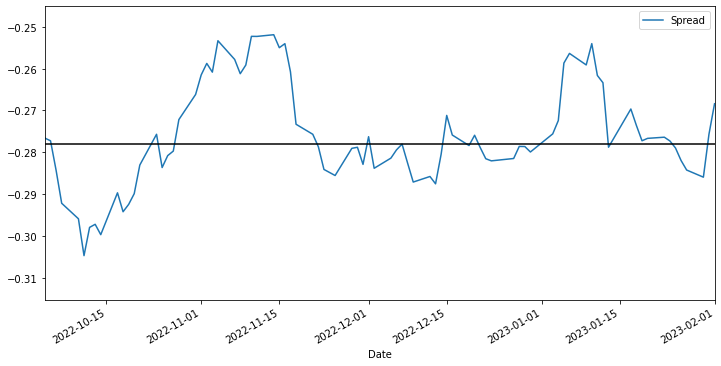

In [65]:
spread1[0].plot(figsize=(12,6))
plot.axhline(spread1[0].mean(), color='black')
plot.xlim('2022-10-04', '2023-02-01')
plot.legend(['Spread']);

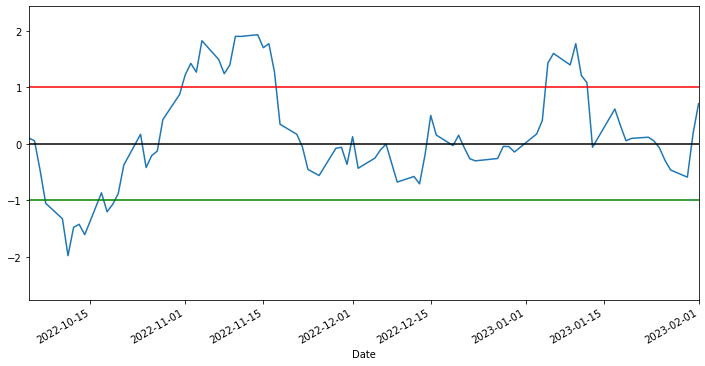

In [66]:
spread1[1].plot(figsize=(12,6))
plot.axhline(spread1[1].mean(),color='black')
plot.axhline(1.0, color='red')
plot.axhline(-1.0, color='green')
plot.xlim('2022-10-04', '2023-02-01')
plot.show()

In [ ]:
#Get latest data everyday to check z-score from Top20 pairs
stock = pd.DataFrame()
for i in list(log_data.columns.values):  
    try:
        stock1 = []
        stock1 = yf.download(i,start=start, end=end, progress=False)
        if len(stock1) == 0:
            None
        else:
            stock1['ticker']=i
            stock = stock.append(stock1,sort=False)
    except Exception:
        None

Trading Part

In [ ]:
stockdata = stock.pivot_table(index=['Date'], columns=stock['ticker'], values=['Adj Close'])
stockdata = np.log(stockdata)

In [69]:
top20_copy = top20.copy()

In [73]:
A = []
B = []
spreaddata = []
for i in range (0,20):
    a = top20['StockA'][i]
    b = top20['StockB'][i]
    A.append(a)
    B.append(b)
    sd = spread(A[i],B[i])[1][-1]
    spreaddata.append(sd)
top20_copy['Z-score'] = spreaddata
top20_copy.to_csv("pairs-data.csv", index=False)

In [ ]:
try:
    ib.disconnect()
    time.sleep(5)
except:
    print("no ib connection to disconnect")

# initialize connection to IBKR
ib = IB()
ib.connect('127.0.0.1', 7497, clientId=10)  # IB Trader Workstation

In [ ]:
for i in range(0,20):
    if portfolio_val == 0:
        trade(i)
    else:
        rebalance(i)  

In [ ]:
ib.positions()